In [1]:
using Gadfly

# Athena/Phoenix Simulation

## Underlying simulation

In order to price the autocallable bonds, we need to simulate the underlying assets. Let's go ahead and set up the simulation first, as this lays the foundation for what we're trying to do. We're going to use [JNJ](http://finance.yahoo.com/q?s=jnj) as the basis for our simulation. This implies the following parameters:

- $S_0$ = \$102.2 (as of time of writing)
- $q$ = 2.84%
- $r$ = [.49, .9, 1.21, 1.45, 1.69] (term structure as of time of writing, linear interpolation)
- $\mu$ = $r - q$ (note that this implies a negative drift because of current low rates)
- $\sigma$ = $\sigma_{imp}$ = 15.62% (from VIX implied volatility)

We additionally define some parameters for simulation:

- `T`: The number of years to simulate
- `m`: The number of paths to simulate
- `n`: The number of steps to simulate in a year

In [2]:
S0 = 102.2
nominal = 100
q = 2.84 / 100
σ = 15.37 / 100
term = [0, .49, .9, 1.21, 1.45, 1.69] / 100 + 1

###
# Potential: Based on PEP
# S0 = 100.6
# σ = 14.86
# q = 2.7
###

# Simulation parameters
T = 5 # Using years as the unit of time
n = 250 # simulations per year
m = 100000 # paths
num_simulations = 5; # simulation rounds per price

5

### Defining the simulation
To make things simpler, we simulate a single year at a time. This allows us to easily add in a dividend policy without too much difficulty, and update the simulation every year to match the term structure. The underlying uses GBM for simulation between years.

In [3]:
simulate_gbm = function(S0, μ, σ, T, n)
    # Set the initial state
    m = length(S0)
    t = T / n
    motion = zeros(m, n)
    motion[:,1] = S0
    
    # Build out all states
    for i=1:(n-1)
        motion[:,i+1] = motion[:,i] .* exp((μ - σ^2/2)*t) .* exp(sqrt(t) * σ .* randn(m))
    end
    
    return motion
end

function display_motion(motion, T)
    # Given a matrix of paths, display the motion
    n = length(motion[1,:])
    m = length(motion[:,1])
    x = repmat(1:n, m)
    
    # Calculate the ticks we're going to use. We'd like to
    # have an xtick every month, so calculate where those
    # ticks will actually be at.
    if (T > 3)
        num_ticks = T
        xlabel = "Years"
    else
        num_ticks = T * 12
        xlabel = "Months"
    end
    tick_width = n / num_ticks
    x_ticks = []
    for i=1:round(num_ticks)
        x_ticks = vcat(x_ticks, i*tick_width)
    end
    
    # Use one color for each path. I'm not sure if there's
    # a better way to do this without going through DataFrames
    colors = []
    for i = 1:m
        colors = vcat(colors, ones(n)*i)
    end
    
    plot(x=x, y=motion', color=colors, Geom.line,
    Guide.xticks(ticks=x_ticks, label=false),
    Guide.xlabel(xlabel),
    Guide.ylabel("Value"))
end;

### Example simulation

Let's go ahead and run a sample simulation to see what the functions got us!

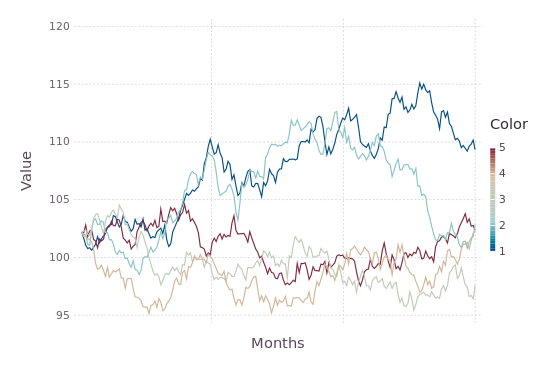

In [4]:
initial = ones(5) * S0
# Using μ=0, T=.25 for now, we'll use the proper values later
motion = simulate_gbm(initial, 0, σ, .25, 200) 

display_motion(motion, .25)

### Computing the term structure

Now that we've got the basic motion set up, let's start making things a bit more sophisticated for the model. We're going to assume that the drift of the stock is the difference between the implied forward rate and the quarterly dividend rate.

We're given the yearly term structure, and need to calculate the quarterly forward rate to match this structure. The term structure is assumed to follow:

$d(0, t) = d(0,t-1)\cdot f_{i-1, i}$

Where $f_{i-1, i}$ is the quarterly forward rate.

In [5]:
forward_term = function(yearly_term)
    # It is assumed that we have a yearly term structure passed in, and starts at year 0
    # This implies a nominal rate above 0 for the first year!
    years = length(term)-1 # because we start at 0
    structure = [(term[i+1] / term[i]) for i=1:years]
end;

### Illustrating the term structure

Now that we've got our term structure, let's validate that we're getting the correct results! If we've done this correctly, then:

```
term[2] == term[1] * structure[1]
```

In [6]:
# Example term structure taken from:
# http://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield
# Linear interpolation used years in-between periods, assuming real-dollar
# interest rates
forward_yield = forward_term(term)
calculated_term2 = term[1] * forward_yield[1]

println("Actual term[2]: $(term[2]); Calculated term[2]: $(calculated_term2)")

Actual term[2]: 1.0049; Calculated term[2]: 1.0049


### The full underlying simulation

Now that we have the term structure set up, we can actually start doing some real simulation! Let's construct some paths through the full 5-year time frame. In order to do this, we will simulate 1 year at a time, and use the forward rates at those times to compute the drift. Thus, there will be 5 total simulations batched together.

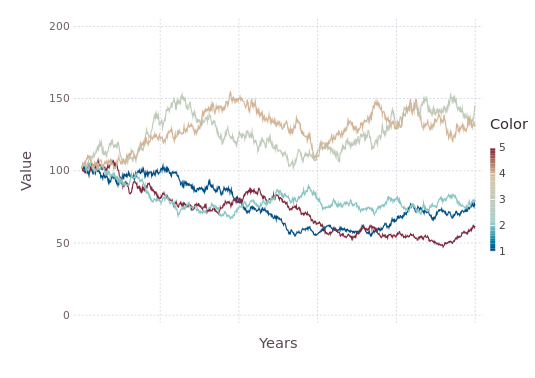

In [7]:
full_motion = ones(5) * S0
full_term = vcat(term[1], forward_yield)
for i=1:T
    μ = (full_term[i] - 1 - q)
    year_motion = simulate_gbm(full_motion[:,end], μ, σ, 1, n)
    full_motion = hcat(full_motion, year_motion)
end

display_motion(full_motion, T)

### Final simulation

We're now going to actually build out the full motion that we'll use for computing the pricing of our autocallable products. It will be largely the same, but we will use far more sample paths for the simulation.

In [8]:
full_simulation = function(S0, T, n, m, term)
    forward = vcat(term[1], forward_term(term))

    # And an S0 to kick things off.
    final_motion = ones(m) * S0
    for i=1:T
        μ = (forward[i] - 1 - q)
        year_motion = simulate_gbm(final_motion[:,end], μ, σ, 1, n)
        final_motion = hcat(final_motion, year_motion)
    end
    return final_motion
end

tic()
full_simulation(S0, T, n, m, term)
time = toq()
@printf("Time to run simulation: %.2fs", time)

Time to run simulation: 5.34s

## Athena Simulation

Now that we've defined our underlying simulation, let's actually try and price an Athena note. Athena has the following characteristics:

- Automatically called if the underlying is above the **call barrier** at observation
- Accelerated coupon paid if the underlying is above the **call barrier** at observation
    - The coupon paid is $c \cdot i$ with $i$ as the current year, and $c$ the coupon rate
- Principle protection up until a **protection barrier** at observation; All principle at risk if this barrier not met
- Observed yearly

In [9]:
call_barrier = S0
strike = S0
protection_barrier = S0 * .6
coupon = nominal * .07

price_athena = function(initial_price, year_prices, call_barrier,
        protection_barrier, coupon, forward_structure)

    total_coupons = 0
    
    t = length(year_prices)

    for i=1:t
        price = year_prices[i]
        if price ≥ call_barrier
            return (nominal + coupon*i) * exp((prod(forward_structure[i:end])-1)*(t-i))
        end
    end

    # We've reached maturity, time to check capital protection
    if year_prices[end] > protection_barrier
        return nominal
    else
        put = (strike - year_prices[end]) / strike
        return nominal*(1-put)
    end
end

forward_structure = forward_term(term)
price_function = (year_prices) -> price_athena(S0, year_prices,
    call_barrier, protection_barrier, coupon, forward_structure)

athena = function()
    year_indexes = [n*i for i=1:T]
    motion = full_simulation(S0, T, n, m, term)
    payoffs = [price_function(motion[i, year_indexes]) for i=1:m]
    return mean(payoffs)
end

mean_payoffs = zeros(num_simulations)
for i=1:num_simulations
    tic()
    mean_payoffs[i] = athena()
    time = toq()
    @printf("Mean of simulation %i: \$%.4f; Simulation time: %.2fs\n", i, mean_payoffs[i], time)
end

final_mean = mean(mean_payoffs)
println("Mean over $num_simulations simulations: $(mean(mean_payoffs))")
pv = final_mean * (exp(-(prod(forward_structure)-1)*T))
@printf("Present value of Athena note: \$%.2f, notional: \$%.2f", pv, nominal)

Mean of simulation 1: $103.2805; Simulation time: 5.59s
Mean of simulation 2: $103.3796; Simulation time: 5.05s
Mean of simulation 3: $103.4752; Simulation time: 5.18s
Mean of simulation 4: $103.4099; Simulation time: 5.37s
Mean of simulation 5: $103.3260; Simulation time: 5.32s
Mean over 5 simulations: 103.37421610015554
Present value of Athena note: $95.00, notional: $100.00

## Phoenix without Memory Simulation

Let's move into pricing a Phoenix without memory. It's very similar to the Athena production, with the exception that we introduce a coupon barrier so coupons are paid even when the underlying is below the initial price.

The Phoenix product has the following characteristics (example [here](https://www.rbccm.com/usstructurednotes/file-780079.pdf)):

- Automatically called if the underlying is above the **call barrier** at observation
- Coupon paid if the underlying is above a **coupon barrier** at observation
- Principle protection up until a **protection barrier** at observation; All principle at risk if this barrier not met
- Observed yearly

Some example paths (all assume that a call barrier of the current price, and coupon barrier some level below that):

- At the end of year 1, the stock is above the call barrier; the note is called and you receive the value of the stock plus the coupon being paid.
- At the end of year 1, the stock is above the coupon barrier, but not the call barrier; you receive the coupon. At the end of year 2, the stock is below the coupon barrier; you receive nothing. At the end of year 3, the stock is above the call barrier; the note is called and you receive the value of the stock plus a coupon for year 3.

We're going to re-use the same simulation, with the following parameters:

- Call barrier: 100%
- Coupon barrier: 70%
- Coupon: 6%
- Capital protection until 70% (at maturity)

In [10]:
call_barrier = S0
coupon_barrier = S0 * .8
protection_barrier = S0 * .6
coupon = nominal * .06

price_phoenix_no_memory = function(initial_price, year_prices, call_barrier, coupon_barrier,
        protection_barrier, coupon, forward_structure)

    total_coupons = 0
    t = length(year_prices)

    for i=1:t
        price = year_prices[i]
        if price ≥ call_barrier
            return (nominal + coupon + total_coupons)*exp((prod(forward_structure[i:end])-1)*(t-i))
        elseif price ≥ coupon_barrier
            total_coupons = total_coupons * exp(forward_structure[i]-1) + coupon
        else
            total_coupons *= exp(forward_structure[i]-1)
        end
    end

    # We've reached maturity, time to check capital protection
    if year_prices[end] > protection_barrier
        return nominal + total_coupons
    else
        put = (strike - year_prices[end]) / strike
        return nominal*(1-put)
    end
end

forward_structure = forward_term(term)
price_function = (year_prices) -> price_phoenix_no_memory(S0, year_prices,
    call_barrier, coupon_barrier, protection_barrier, coupon, forward_structure)

phoenix_no_memory = function()
    year_indexes = [n*i for i=1:T]
    motion = full_simulation(S0, T, n, m, term)
    payoffs = [price_function(motion[i, year_indexes]) for i=1:m]
    return mean(payoffs)
end

mean_payoffs = zeros(num_simulations)
for i=1:num_simulations
    tic()
    mean_payoffs[i] = phoenix_no_memory()
    time = toq()
    @printf("Mean of simulation %i: \$%.4f; Simulation time: %.2fs\n", i, mean_payoffs[i], time)
end

final_mean = mean(mean_payoffs)
println("Mean over $num_simulations simulations: $(mean(mean_payoffs))")
pv = final_mean * exp(-(prod(forward_structure)-1)*(T))
@printf("Present value of Phoenix without memory note: \$%.2f", pv)

Mean of simulation 1: $106.0562; Simulation time: 5.72s
Mean of simulation 2: $106.0071; Simulation time: 5.85s
Mean of simulation 3: $105.9959; Simulation time: 5.87s
Mean of simulation 4: $106.0665; Simulation time: 5.93s
Mean of simulation 5: $106.0168; Simulation time: 5.81s
Mean over 5 simulations: 106.02850857209883
Present value of Phoenix without memory note: $97.44

## Phoenix with Memory Simulation

The Phoenix with Memory structure is very similar to the Phoenix, but as the name implies, has a special "memory" property: **It remembers any coupons that haven't been paid at prior observation times, and pays them all if the underlying crosses the coupon barrier**. For example:
- Note issued with 100% call barrier, 70% coupon barrier. At year 1, the underlying is at 50%, so no coupons are paid. At year 2, the underlying is at 80%, so coupons for both year 1 and 2 are paid, resulting in a double coupon.

You can also find an example [here](https://www.rbccm.com/usstructurednotes/file-781232.pdf).

Let's go ahead and set up the simulation! The parameters will be the same, but we can expect that the value will go up because of the memory attribute

In [11]:
call_barrier = S0
coupon_barrier = S0 * .8
protection_barrier = S0 * .6
coupon = nominal * .07

price_phoenix_with_memory = function(initial_price, year_prices, call_barrier,
    coupon_barrier, protection_barrier, coupon, forward_structure)

    last_coupon = 0
    total_coupons = 0
    
    t = length(year_prices)

    for i=1:t
        price = year_prices[i]
        if price > call_barrier
            return (nominal + coupon + total_coupons)*exp((prod(forward_structure[i:end])-1)*(t-i))
        elseif price > coupon_barrier
            ####################################################################
            # The only difference between with/without memory is the below lines
            memory_coupons = (i - last_coupon) * coupon
            last_coupon = i
            total_coupons = total_coupons * exp(forward_structure[i]-1) + memory_coupons
            ####################################################################
        else
            total_coupons *= exp(forward_structure[i]-1)
        end
    end

    # We've reached maturity, time to check capital protection
    if year_prices[end] > protection_barrier
        return nominal + total_coupons
    else
        put = (strike - year_prices[end]) / strike
        return nominal*(1-put)
    end
end

forward_structure = forward_term(term)
price_function = (year_prices) -> price_phoenix_with_memory(S0, year_prices,
    call_barrier, coupon_barrier, protection_barrier, coupon, forward_structure)

phoenix_with_memory = function()
    year_indexes = [n*i for i=1:T]
    motion = full_simulation(S0, T, n, m, term)
    payoffs = [price_function(motion[i, year_indexes]) for i=1:m]
    return mean(payoffs)
end

mean_payoffs = zeros(num_simulations)
for i=1:num_simulations
    tic()
    mean_payoffs[i] = phoenix_with_memory()
    time = toq()
    @printf("Mean of simulation %i: \$%.4f; Simulation time: %.2fs\n",
        i, mean_payoffs[i], time)
end

final_mean = mean(mean_payoffs)
println("Mean over $num_simulations simulations: $(mean(mean_payoffs))")
pv = final_mean * exp(-(prod(forward_structure)-1)*(T))
@printf("Present value of Phoenix with memory note: \$%.2f", pv)

Mean of simulation 1: $108.8612; Simulation time: 5.89s
Mean of simulation 2: $109.0226; Simulation time: 5.90s
Mean of simulation 3: $108.9175; Simulation time: 5.92s
Mean of simulation 4: $108.9426; Simulation time: 5.94s
Mean of simulation 5: $108.8087; Simulation time: 6.06s
Mean over 5 simulations: 108.91052564051816
Present value of Phoenix with memory note: $100.09